## Visualize results of the linear model

In [1]:
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(dplyr))

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”


In [2]:
# Focusing on plate 3
plate <- "localhost230405150001"

input_dir <- "results"
lm_file <- file.path(input_dir, paste0(plate, "_linear_model_DMSO_failing_healthy.tsv"))

output_fig_dir <- "figures"
lm_fig <- file.path(output_fig_dir, paste0(plate, "_linear_model_DMSO_failing_healthy.png"))

In [3]:
# Load and process linear model data
lm_df <- readr::read_tsv(
    lm_file, col_types = readr::cols(.default = "d", feature = "c")
)

# Arrange by absolute value coefficient
# Split out components of feature name for visualization
lm_df <- lm_df %>%
    dplyr::arrange(desc(abs(failing_coef))) %>%
    tidyr::separate(
        feature,
        into = c(
            "compartment",
            "feature_group",
            "measurement",
            "channel", 
            "parameter1", 
            "parameter2"
        ),
        sep = "_",
        remove = FALSE
    ) %>%
    dplyr::mutate(channel_cleaned = channel)

lm_df$channel_cleaned <- dplyr::recode(lm_df$channel_cleaned,
    "Hoechst" = "Nucleus",
    "ER" = "ER",
    "Actin" = "Actin",
    "Mitochondria" = "Mito",
    "PM" = "Plasma membrane",
    .default = "other",
    .missing = "other"
)

print(dim(lm_df))
head(lm_df, 3)

Warning message:
“Expected 6 pieces. Additional pieces discarded in 233 rows [1, 5, 6, 8, 18, 21,
22, 23, 24, 25, 27, 28, 29, 30, 33, 34, 40, 41, 43, 45, ...].”
Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 322 rows [2, 3, 4, 7, 9,
10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 26, 31, 32, 35, 36, ...].”


[1] 555  12


feature,compartment,feature_group,measurement,channel,parameter1,parameter2,r2_score,cell_count_coef,failing_coef,healthy_coef,channel_cleaned
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Nuclei_Texture_DifferenceVariance_Actin_3_01_256,Nuclei,Texture,DifferenceVariance,Actin,3,01,0.5682826,-0.0003519498,-0.8406034,0.8406034,Actin
Cells_Intensity_IntegratedIntensityEdge_Actin,Cells,Intensity,IntegratedIntensityEdge,Actin,NA,NA,0.2538496,0.0004323932,0.7153039,-0.7153039,Actin
Nuclei_Intensity_LowerQuartileIntensity_Hoechst,Nuclei,Intensity,LowerQuartileIntensity,Hoechst,NA,NA,0.2091811,0.0006367227,-0.6919379,0.6919379,Nucleus


## Visualize linear modeling results

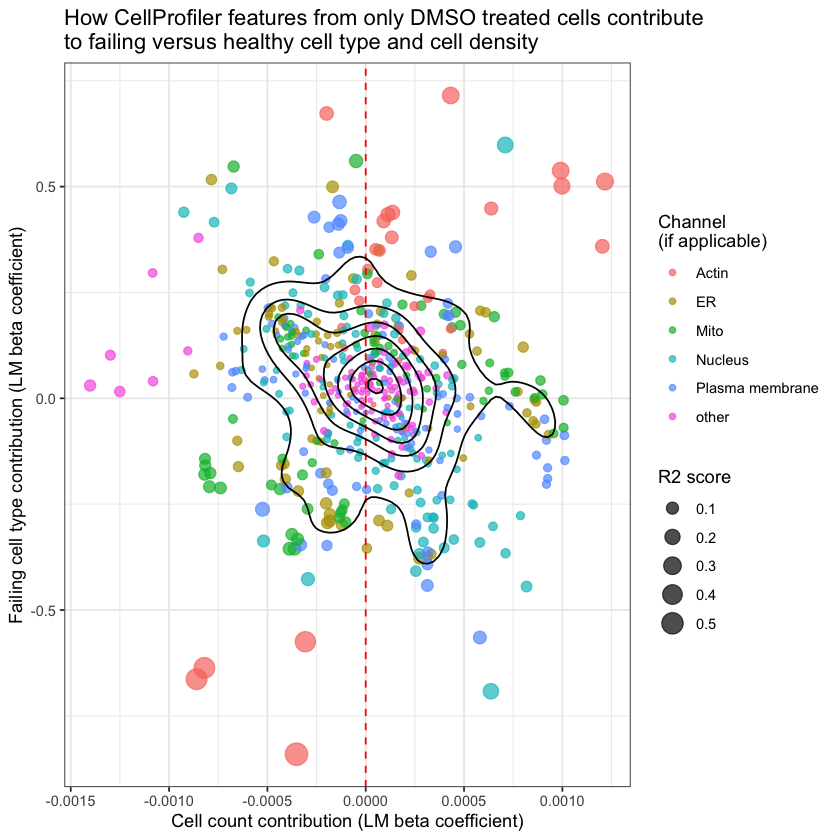

In [4]:
lm_fig_gg <- (
    ggplot(lm_df, aes(x = cell_count_coef, y = failing_coef))
    + geom_point(aes(size = r2_score, color = channel_cleaned), alpha = 0.7)
    + geom_vline(xintercept = 0, linetype = "dashed", color = "red")
    + geom_density2d(color="black", show.legend = FALSE)
    + theme_bw()
    + guides(
        color = guide_legend(title = "Channel\n(if applicable)", order = 1),
        size = guide_legend(title = "R2 score")
    )
    + ylab("Failing cell type contribution (LM beta coefficient)")
    + xlab("Cell count contribution (LM beta coefficient)")
    + ggtitle("How CellProfiler features from only DMSO treated cells contribute\nto failing versus healthy cell type and cell density")
)

# Output figure
ggsave(lm_fig, lm_fig_gg, dpi = 500, height = 6, width = 6)

lm_fig_gg